In [10]:
import json
import numpy as np


###### Q1.1 ######
def objective_function(X, y, w, lamb):
    """
    Inputs:
    - Xtrain: A 2 dimensional numpy array of data (number of samples x number of features)
    - ytrain: A 1 dimensional numpy array of labels (length = number of samples )
    - w: a numpy array of D elements as a D-dimension weight vector
    - lamb: lambda used in pegasos algorithm

    Return:
    - obj_value: the value of objective function in SVM primal formulation
    """
    # you need to fill in your solution here
    
    # 0.5 * lamb * ||w||^2 + 1/N sum(max(0,1-ywx))  
    X = np.array(X)
    y = np.array(y)

    N = X.shape[0]
    z = 1- np.multiply(y, np.transpose(np.dot(X,w)))
    zmax = z[z>0]
    obj_value = 0.5 * lamb * (np.linalg.norm(w) **2) + np.sum(zmax) / N
    #print(obj_value)

    return obj_value


###### Q1.2 ######
def pegasos_train(Xtrain, ytrain, w, lamb, k, max_iterations):
    """
    Inputs:
    - Xtrain: A list of num_train elements, where each element is a list of D-dimensional features.
    - ytrain: A list of num_train labels
    - w: a numpy array of D elements as a D-dimension vector, which is the weight vector and initialized to be all 0s
    - lamb: lambda used in pegasos algorithm
    - k: mini-batch size
    - max_iterations: the total number of iterations to update parameters

    Returns:
    - learnt w
    - train_obj: a list of the objective function value at each iteration during the training process, length of 500.
    """
    np.random.seed(0)
    Xtrain = np.array(Xtrain)
    ytrain = np.array(ytrain)
    N = Xtrain.shape[0]
    D = Xtrain.shape[1]

    train_obj = []

    for iter in range(1, max_iterations + 1):
        A_t = np.floor(np.random.rand(k) * N).astype(int)  # index of the current mini-batch

        # you need to fill in your solution here
        X_t = Xtrain[A_t, :]
        y_t = ytrain[A_t]
        
        # 4
        #A_tpls = A_t[np.multiply(y_t, np.dot(X_t,w)) < 1]
        A_tpls = A_t[(np.multiply(y_t, np.transpose(np.dot(X_t,w)) )<1).ravel()]
        X_tpls = Xtrain[A_tpls, :]
        y_tpls = ytrain[A_tpls]
        
        # 5
        ita_t = 1/(lamb * iter)
        
        
        # 6
        w_thalf = (1 - (ita_t * lamb)) * w + ita_t * np.sum(
            np.multiply(y_tpls.reshape(y_tpls.shape[0],1),X_tpls),
            axis=0).reshape(D,1)/ k
        
        # 7
        #w = w_thalf * min(1,1/(np.sqrt(lamb) * np.linalg.norm(np.array(w_thalf))))
        if not np.linalg.norm(w_thalf) ==0:
            w = w_thalf * min(1, 1 / np.sqrt(lamb) / np.linalg.norm(w_thalf))
        else:
            w = w_thal
        
        train_obj.append(objective_function(Xtrain, ytrain, w, lamb))
        print(train_obj[iter-1])
        # print(w[0])
    

    return w, train_obj


###### Q1.3 ######
def pegasos_test(Xtest, ytest, w_l):
    """
    Inputs:
    - Xtest: A list of num_test elements, where each element is a list of D-dimensional features.
    - ytest: A list of num_test labels
    - w_l: a numpy array of D elements as a D-dimension vector, which is the weight vector of SVM classifier and learned by pegasos_train()
 
    Returns:
    - test_acc: testing accuracy.
    """
    # you need to fill in your solution here
    Xtest = np.array(Xtest)
    ytest = np.array(ytest)
    N = Xtest.shape[0]
    ywx = (np.multiply(ytest, np.transpose(np.dot(Xtest, w_l))) > 0).ravel()
    ytru = ytest > 0
    test_acc = sum(ytru == ywx)/N


    return test_acc


"""
NO MODIFICATIONS below this line.
You should only write your code in the above functions.
"""

def data_loader_mnist(dataset):

    with open(dataset, 'r') as f:
            data_set = json.load(f)
    train_set, valid_set, test_set = data_set['train'], data_set['valid'], data_set['test']

    Xtrain = train_set[0]
    ytrain = train_set[1]
    Xvalid = valid_set[0]
    yvalid = valid_set[1]
    Xtest = test_set[0]
    ytest = test_set[1]

    ## below we add 'one' to the feature of each sample, such that we include the bias term into parameter w
    Xtrain = np.hstack((np.ones((len(Xtrain), 1)), np.array(Xtrain))).tolist()
    Xvalid = np.hstack((np.ones((len(Xvalid), 1)), np.array(Xvalid))).tolist()
    Xtest = np.hstack((np.ones((len(Xtest), 1)), np.array(Xtest))).tolist()

    for i, v in enumerate(ytrain):
        if v < 5:
            ytrain[i] = -1.
        else:
            ytrain[i] = 1.
    for i, v in enumerate(ytest):
        if v < 5:
            ytest[i] = -1.
        else:
            ytest[i] = 1.

    return Xtrain, ytrain, Xvalid, yvalid, Xtest, ytest


def pegasos_mnist():

    test_acc = {}
    train_obj = {}

    Xtrain, ytrain, Xvalid, yvalid, Xtest, ytest = data_loader_mnist(dataset = 'mnist_subset.json')

    max_iterations = 500
    k = 100
    for lamb in (0.01, 0.1, 1):
        w = np.zeros((len(Xtrain[0]), 1))
        w_l, train_obj['k=' + str(k) + '_lambda=' + str(lamb)] = pegasos_train(Xtrain, ytrain, w, lamb, k, max_iterations)
        test_acc['k=' + str(k) + '_lambda=' + str(lamb)] = pegasos_test(Xtest, ytest, w_l)

    lamb = 0.1
    for k in (1, 10, 1000):
        w = np.zeros((len(Xtrain[0]), 1))
        w_l, train_obj['k=' + str(k) + '_lambda=' + str(lamb)] = pegasos_train(Xtrain, ytrain, w, lamb, k, max_iterations)
        test_acc['k=' + str(k) + '_lambda=' + str(lamb)] = pegasos_test(Xtest, ytest, w_l)

    return test_acc, train_obj


def main():
    test_acc, train_obj = pegasos_mnist() # results on mnist
    print('mnist test acc \n')
    for key, value in test_acc.items():
        print('%s: test acc = %.4f \n' % (key, value))

    with open('pegasos.json', 'w') as f_json:
        json.dump([test_acc, train_obj], f_json)


if __name__ == "__main__":
    main()


5.843716417366739
30.224789213322254
29.396770332610398
29.578718950170796
29.028962880212347
29.548984795919427
28.424214518492082
28.891763821278758
27.11142883710654
28.44628527844209
27.78978744523796
26.961850424221623
25.700792011589026
25.639301861309193
24.201125812616745
24.621802948142193
21.11169363644928
18.42818217950922
18.568923162166925
19.04746099821055
13.695604672776623
19.0991025513426
7.315862445499761
13.251238816406028
14.232412124452047
10.104304167433673
13.126181314125596
13.018705547679499
13.554034490513551
11.705812290079935
8.27013256503126
11.4859868937944
11.40912673862703
9.070986023149352
9.306375766476586
9.49202086644731
10.094163082094974
8.450219724477968
8.503044727031028
6.238833796830192
10.041480169400831
5.920308692454151
5.974495457862558
6.246121802843939
6.247664529663021
4.499533748381965
3.9959834614037484
2.523718351699638
1.9984260068290682
1.812655086895431
1.7094953123029786
1.859411076647226
1.7326929083633424
3.4478012975559666
7.55

0.4350208454467438
0.4223280088307563
0.42269711944182076
0.42641321586604153
0.4388240105393551
0.42107144112551137
0.4207296060790465
0.4233332698907232
0.4603600659171616
0.4275260892983771
0.438526178284668
0.4202808048927642
0.43477106738288673
0.4279581732031412
0.5130970798036176
0.5546832724107761
0.5309709020096042
0.5966210084572148
0.4530327727995433
0.48023760695538453
0.6646102727277994
0.7416924579611573
0.7577643343542947
0.6972766777241214
0.7137013064734331
0.4966032162846176
0.48824264564234876
0.45310704797568113
0.4500819671569294
0.4399570857765379
0.46362933753499347
0.4233633887509757
0.4251571446309793
0.416765810275409
0.4319624248667662
0.4272736825497675
0.435001228266344
0.4195014084103774
0.4340170336706322
0.45337213807027305
0.46674071047231613
0.4356425219438846
0.6403924771978957
0.6877820014683756
0.6982134268598517
0.42118341679506155
0.4521771047446025
0.42446770631648106
0.44965565021065873
0.4330200509212771
0.41433963461932244
0.4117790004387038
0

0.506577133062814
0.5092841550924246
0.5065161054948675
0.5064967352013732
0.5062509310515718
0.5061466845791313
0.5065897032054176
0.5059540925117885
0.5062609587931381
0.506217237162118
0.5089337498193399
0.5062575282932298
0.5064400385924069
0.5062597200570659
0.5058708041028218
0.5058819933004767
0.5061358962214841
0.5062484017298576
0.5068604607030166
0.5110751238284253
0.5069984260574062
0.5121156517356381
0.5062654943715958
0.5067830803410002
0.509312181420284
0.5060125939951201
0.5063299541969485
0.5065336605075611
0.5065152655144693
0.5119722387571624
0.5069622878967796
0.5063018081532346
0.5064136693041006
0.5069689935577169
0.5066670014382083
0.5071442066698818
0.5069926191724228
0.507913073830249
0.506427065309017
0.5068333009394198
0.5106180025670471
0.5148573772534181
0.5083259511474799
0.507423191399856
0.5078864891923224
0.5071350139817952
0.5063671460214952
0.5061100967930466
0.5061601621786163
0.505966482375868
0.5075988116761719
0.5089692703468944
0.5064316190189956


0.7258531113446712
0.7259449748779596
0.7264746735783044
0.726233046602769
0.7263522325682154
0.7264750094641428
0.7259651276595456
0.7260581784233212
0.7267513534127412
0.7272343247533803
0.7265446770984743
0.7259537704745243
0.726660593585188
0.7266705683417457
0.7261150486113591
0.7263589339523483
0.7259967670646071
0.7261346463751609
0.7262757799697086
0.7261146974305465
0.725988898769216
0.7259940364281031
0.7259487253339931
0.7257684125026009
0.7254910854248137
0.7255667688643235
0.7254224067853987
0.7255740054612326
0.7261046203960586
0.725664016623079
0.7260306673341892
0.7256843703499578
0.7253857664107444
0.7252370083360064
0.7252968069061803
0.7253531537385783
0.7255222409691346
0.725771349902232
0.7258641698893115
0.7256704538595623
0.7256226037205157
0.7257914178339284
0.7256568423527621
0.7255132268886082
0.7255069240551935
0.7253800044940754
0.725221267032043
0.7252072541009449
0.7251912397648974
0.7252037153609427
0.7252617166508692
0.7252349056532167
0.7252475072043538

1.418816043864647
0.9312636760501709
0.9283852688773736
0.9255409901436871
1.1935178127696684
1.1897972551829548
1.1861136033379327
1.182466089696507
0.949680776641889
1.1608275124037668
0.9734587669536029
0.9705847141164603
1.23504073262398
1.2314274144400665
1.227848248047252
0.9631966227129002
1.1266441843750064
1.1233171263480473
1.4854513770410245
1.480953255857554
1.476493665814177
1.0526634380017708
0.9493077149137441
1.1657325842333455
0.9766416634421109
1.4160334244023591
1.4121288886016576
1.0799639680864777
1.0561452885137996
1.0533885792705207
1.110968629096908
1.0557934323441434
1.0532038323457968
1.1443245767920203
1.141418580820693
0.9540369806695601
0.9517168796008382
0.9494182419284329
0.9861157410438663
0.9026200721707673
0.9266869150821818
0.9098920421628651
0.9141656249596821
1.1556239184975707
1.152650922678557
1.1497033352501638
1.1467811776902181
1.1438845440285945
1.1410124136327573
1.1381651728312234
1.1353435255297213
0.8145581081348714
0.8879052889385768
0.85

0.5659690698355032
0.5652221379315951
0.5646220980650533
0.5500347931334588
0.5743983448294689
0.6065276344766571
0.563190681551782
0.539016075427355
0.5401779354881586
0.5378019562636284
0.6035932419520085
0.6218189446247799
0.5789934248674092
0.5671702661079323
0.5521527051579873
0.595547357136224
0.5497333621070075
0.7048168235060993
0.6063908751511715
0.5419570438072597
0.5418928026926053
0.6833015623403076
0.5468528971679076
0.6726080167248404
0.6133019765457063
0.5366024066680302
0.5587278387553115
0.5731418877236629
0.5386176857529229
0.5508582517018059
0.5371787878497122
0.5439994031735277
0.5358074888190939
0.5435570145155828
0.5826997456574067
0.5367439194515888
0.6188397258538173
0.552656385053307
0.5452074830235716
0.5657037957082675
0.5470429040274631
0.5390664651801728
0.5767848797956182
0.6322319060761024
0.5916140067381834
0.5574918346779386
0.5451324312681783
0.5448449838749737
0.5554776124779409
0.5990714191052342
0.5571771437074399
0.6083431611559595
0.56851037191008

0.5049490007522003
0.5054544690598608
0.5073950899648014
0.5055305403603894
0.5053411522434744
0.5076101459358469
0.5071924987024842
0.506860707931517
0.5078599055747863
0.5098361422796824
0.5052404144792795
0.5058595923536126
0.5048545293731209
0.5047811358347911
0.505067581430187
0.5064220227557529
0.5070258644762076
0.5047903537268591
0.5056538974157194
0.5050976352890916
0.5074068318754295
0.5051380352174124
0.5047326894173977
0.504733730879718
0.5054332286600461
0.5047786214654
0.504565139030412
0.5053602106240489
0.5064356029478776
0.5056180497040532
0.5045382806297141
0.5044729498718971
0.5045434277100826
0.5047974949244731
0.5046195212094143
0.5046526018393511
0.5045340599623356
0.5058526803049435
0.5046667459242157
0.504764295392494
0.5047844997817624
0.50618625805257
0.5070118786732215
0.5045528086412134
0.5068476271599289
0.506746530195799
0.5062922804319133
0.5046331873773099
0.5044261670547724
0.5046927853606085
0.5048427977684458
0.5050976662697365
0.5046766053237521
0.50

## 1.1

In [2]:
Xtrain, ytrain, Xvalid, yvalid, Xtest, ytest = data_loader_mnist(dataset = 'mnist_subset.json')
X = np.array(Xtrain)
y = np.array(ytrain)
N = X.shape[0]
D = X.shape[1]
w = np.ones((D,1))
lamb = 0.5

In [4]:
    # 0.5 * lamb * ||w||^2 + 1/N sum(max(0,1-ywx)) 
    
    X = np.array(X)
    y = np.array(y)

    D = X.shape[1]
    z = 1- np.multiply(y, np.transpose(np.dot(X,w)))
    zmax = z[z>0]
    obj_value = 0.5 * lamb * (np.linalg.norm(w) **2 ) + np.sum(zmax) / N

## 1.2

In [5]:
k = 1000
max_iterations = 500
w = np.zeros((D,1))
lamb = 0.5

In [86]:
    """
    Inputs:
    - Xtrain: A list of num_train elements, where each element is a list of D-dimensional features.
    - ytrain: A list of num_train labels
    - w: a numpy array of D elements as a D-dimension vector, which is the weight vector and initialized to be all 0s
    - lamb: lambda used in pegasos algorithm
    - k: mini-batch size
    - max_iterations: the total number of iterations to update parameters

    Returns:
    - learnt w
    - train_obj: a list of the objective function value at each iteration during the training process, length of 500.
    """
    np.random.seed(0)
    Xtrain = np.array(Xtrain)
    ytrain = np.array(ytrain)
    N = Xtrain.shape[0]
    D = Xtrain.shape[1]

    train_obj = []

    for iter in range(1, max_iterations + 1):
#    for iter in range(1,30):
        A_t = np.floor(np.random.rand(k) * N).astype(int)  # index of the current mini-batch

        # you need to fill in your solution here
        X_t = Xtrain[A_t, :]
        y_t = ytrain[A_t].astype(int)
        
        # 4
        A_tpls = A_t[(np.multiply(y_t, np.transpose(np.dot(X_t, w)))<1).ravel()]
        X_tpls = Xtrain[A_tpls, :]
        y_tpls = ytrain[A_tpls].astype(int)
        #print('min', min(y_tpls))
        #print('max', max(y_tpls))
        
        # 5
        ita_t = 1/(lamb * iter)
        #print(ita_t)
        
        # 6
        w_thalf = (1-ita_t * lamb) * w + (ita_t / k) * np.sum(
            np.multiply(y_tpls.reshape(y_tpls.shape[0], 1), X_tpls),
            axis=0).reshape(D,1)
        
        # 7
        #w = w_thalf * min(1,1/(np.sqrt(lamb) * np.linalg.norm(np.array(w_thalf))))
        w_ = w
        print(np.linalg.norm(w_thalf))
        w = w_thalf * min(1, 1/(np.sqrt(lamb) * np.linalg.norm(w_thalf)))

        train_obj.append(objective_function(X_t, y_t, w, lamb))
        #print(train_obj[iter-1])
        
    #print(train_obj)


    #return w, train_obj

0.92710240317173
2.799573665940772
1.1711735104241636
0.9889135417648544
0.9507995012292567
0.8135716991462694
0.806213791613021
0.7972111617010312
0.777981848338262
0.7784166338498772
0.7660148351239452
0.7599369389699608
0.7423080670210762
0.722839954521328
0.7053444499392916
0.683891753595169
0.6746281030101371
0.6597227635703051
0.6587316366586422
0.6514266087965418
0.6499520610937997
0.6437100845025393
0.6384841266150869
0.6387445229591764
0.6353801553762549
0.6345829322932705
0.6360677096197667
0.6357822021946509
0.6346700106076135
0.6358877974737873
0.6370034297516821
0.6377325956981745
0.6393059567515549
0.6413408164709637
0.6416703450346182
0.6431953134069864
0.6426174109006499
0.6436415562621193
0.6446427383826484
0.6441188046849974
0.646722226391053
0.6474462356627982
0.6478054836228516
0.6492287742852973
0.6487519910274467
0.6493102121167028
0.6497024909245699
0.6501100148282885
0.6483127910063562
0.6478933977899984
0.6491467282660388
0.6491302939483538
0.6495006637416867
0

0.6605793023934641
0.6606120419465682
0.6606437446820828
0.6604954081444636
0.6605713358359695
0.6607344139339268
0.660660102156858
0.6608213879102097
0.6609459319219592
0.6610891096477404
0.6610447450375068
0.6610806377160064
0.6611882072494224
0.6611009097744428
0.6610873917302088
0.6609851025749343
0.6610787197464252
0.661079010289029
0.6611261771464209
0.6611069042275738
0.6611047878247794
0.6613063097487396
0.6614783844361928
0.6615902075688275
0.6615965596020259
0.6615172379255501
0.661632753702657
0.6616415918650884
0.6616199588518415
0.6616331088620907
0.6616399329509869
0.6615504795435987
0.6617186127102825
0.6615503630516615
0.6613830970316122
0.6614454740116438
0.6613945668865788
0.6614979494003004
0.6614697492716395
0.6616462414698259
0.6616167141128829
0.6615479677567739
0.6616369136237218
0.6614480983526081
0.6615662691869798
0.6615812040538062
0.661528348958158
0.6616196085992502
0.6615584205997087
0.6617011905660377
0.6617179432289645
0.6616093963972549
0.66151111780527

### line 4

In [41]:
A_t[0:10]

array([2716, 1980,  929, 3041,  557, 4739, 2351, 4039,   99, 2166])

In [42]:
A_tpls[0:10]

array([2716, 1980,  929,  557, 4739, 2351, 4039,   99, 2166, 4460])

In [43]:
print(Xtrain[2176,:])
print(ytrain[2176])

[1.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         

In [44]:
np.multiply(ytrain[2176], np.transpose(np.dot(Xtrain[2176,:], w_)))

array([0.63172475])

In [45]:
np.multiply(ytrain[3041], np.transpose(np.dot(Xtrain[3041,:], w_)))

array([1.3147609])

In [46]:
np.linalg.norm(w_)

0.6611226985854638

In [55]:
np.dot(X_tpls, w_).shape

(735, 1)

In [56]:
y_tpls.reshape(y_tpls.shape[0], 1).shape

(735, 1)

In [57]:
a = np.array(range(X_tpls.shape[0]*2)).reshape((X_tpls.shape[0],2))
print(np.multiply(y_tpls.reshape(y_tpls.shape[0], 1) ,a))

[[    0    -1]
 [   -2    -3]
 [    4     5]
 ...
 [-1464 -1465]
 [-1466 -1467]
 [ 1468  1469]]


In [49]:
np.sum( np.multiply(y_tpls.reshape(y_tpls.shape[0], 1) ,a), axis=0)

array([22438, 22467])

### line 5

In [61]:
1/lamb/iter

0.004

In [62]:
1/(lamb * iter)

0.004

### line 6

In [58]:
1-ita_t * lamb

0.998

In [63]:
1 - (ita_t * lamb)

0.998

In [59]:
print(((1-ita_t * lamb) * w_).shape)
print(((1-ita_t * lamb) * w_)[100:105])

(785, 1)
[[0.01638692]
 [0.02061471]
 [0.02567001]
 [0.0257776 ]
 [0.02368338]]


In [54]:
(ita_t / k)

4e-06

In [76]:
print((np.sum(np.multiply(y_tpls.reshape(y_tpls.shape[0], 1), X_tpls),
            axis=0).reshape(D,1)).shape)
print((np.sum(np.multiply(y_tpls.reshape(y_tpls.shape[0], 1), X_tpls),
            axis=0).reshape(D,1))[100:105])

(785, 1)
[[14.24609375]
 [16.66796875]
 [15.91796875]
 [15.1953125 ]
 [11.6875    ]]


In [77]:
((ita_t / k) * np.sum(np.multiply(y_tpls.reshape(y_tpls.shape[0], 1), X_tpls),
            axis=0).reshape(D,1))[100:105]

array([[0.00098249],
       [0.00114952],
       [0.00109779],
       [0.00104795],
       [0.00080603]])

In [78]:
print((np.sum(np.multiply(y_t.reshape(y_t.shape[0], 1), X_t),
            axis=0).reshape(D,1)).shape)
print((np.sum(np.multiply(y_t.reshape(y_t.shape[0], 1), X_t),
            axis=0).reshape(D,1))[100:105])

(785, 1)
[[ 8.90234375]
 [13.3671875 ]
 [12.6484375 ]
 [16.43359375]
 [12.70703125]]


### line 7

In [79]:
1/np.sqrt(lamb)

1.414213562373095

In [80]:
np.linalg.norm(w_thalf)

0.6421561248852019

In [81]:
(1/np.sqrt(lamb)) / np.linalg.norm(w_thalf)

2.2022892993910377

In [84]:
1/ (np.sqrt(lamb) * np.linalg.norm(w_thalf))

2.2022892993910377

In [82]:
min(1, (1/np.sqrt(lamb)) / np.linalg.norm(w_thalf))

1

In [83]:
print(w[100:105])
print((min(1, (1/np.sqrt(lamb)) / np.linalg.norm(w_thalf)) * w_thalf)[100:105])

[[0.01679521]
 [0.02267094]
 [0.02501692]
 [0.02257767]
 [0.01720586]]
[[0.01679521]
 [0.02267094]
 [0.02501692]
 [0.02257767]
 [0.01720586]]


## 1.3

In [ ]:
    max_iterations = 500
    k = 100
    lamb = 0.1
    w = np.zeros((len(Xtrain[0]), 1))
    w_l, train_obj= pegasos_train(Xtrain, ytrain, w, lamb, k, max_iterations)

In [ ]:
    """
    Inputs:
    - Xtest: A list of num_test elements, where each element is a list of D-dimensional features.
    - ytest: A list of num_test labels
    - w_l: a numpy array of D elements as a D-dimension vector, which is the weight vector of SVM classifier and learned by pegasos_train()
 
    Returns:
    - test_acc: testing accuracy.
    """
    # you need to fill in your solution here
    Xtest = np.array(Xtest)
    ytest = np.array(ytest)
    N = Xtest.shape[0]
    #ywx = (np.multiply(ytest, np.transpose(np.dot(Xtest,w_l))) > 0).ravel()
    ywx = np.sign((np.multiply(ytest, np.transpose(np.dot(Xtest,w_l)))).ravel())
    #ytru = ytest > 0
    #test_acc = sum(ytru == ywx)/N
    test_acc = sum(ytest == ywx)/N


    #return test_acc

In [ ]:
w.shape

In [ ]:
test_acc

In [ ]:
len(train_obj)

In [ ]:
np.multiply(ytest, np.transpose(np.dot(Xtest,w_l))).shape

In [ ]:
ytest.shape

In [ ]:
ywx = (np.multiply(ytest, np.transpose(np.dot(Xtest,w_l))) > 0).ravel()
ytru = ytest > 0
sum(ytru * 1 == ywx * 1)

In [ ]:
ytru*1

In [ ]:
yytr=[True, True, False, False]
yyte=[True, False, False, False]
type(yyte)
#sum(yytr == yyte)

In [ ]:
a= np.array([1,2]) > 1
b = np.array([[-1],[2]])>0
a==b

In [ ]:
a==np.transpose(b)

In [ ]:
li = [1,2,3]

In [ ]:
ywx

In [ ]:
ytru

In [ ]:
w_l.shape

In [ ]:
Xtrain.shape

In [ ]:
g = np.array([[1,1],[1,0],[0,1],[-1,-1]])
wg = np.array([[2],[4]])
np.dot(g,wg)

# Convergence curve

In [ ]:
def data_loader_pegasos(dataset):

    with open(dataset, 'r') as f:
            data_set = json.load(f)
    train_set, valid_set, test_set = data_set['train'], data_set['valid'], data_set['test']

    Xtrain = train_set[0]
    ytrain = train_set[1]
    Xvalid = valid_set[0]
    yvalid = valid_set[1]
    Xtest = test_set[0]
    ytest = test_set[1]

    ## below we add 'one' to the feature of each sample, such that we include the bias term into parameter w
    Xtrain = np.hstack((np.ones((len(Xtrain), 1)), np.array(Xtrain))).tolist()
    Xvalid = np.hstack((np.ones((len(Xvalid), 1)), np.array(Xvalid))).tolist()
    Xtest = np.hstack((np.ones((len(Xtest), 1)), np.array(Xtest))).tolist()

    for i, v in enumerate(ytrain):
        if v < 5:
            ytrain[i] = -1.
        else:
            ytrain[i] = 1.
    for i, v in enumerate(ytest):
        if v < 5:
            ytest[i] = -1.
        else:
            ytest[i] = 1.

    return Xtrain, ytrain, Xvalid, yvalid, Xtest, ytest

In [12]:
dataset = 'pegasos.json'
with open(dataset, 'r') as f:
    data_set = json.load(f)
a = data_set[0]['k=10_lambda=0.1']

In [18]:
acc_ = data_set[0]['k=10_lambda=0.1']
obj_ = data_set[1]['k=10_lambda=0.1']

In [24]:
data_set[0]

{'k=100_lambda=0.01': 0.65,
 'k=100_lambda=0.1': 0.568,
 'k=100_lambda=1': 0.564,
 'k=1_lambda=0.1': 0.555,
 'k=10_lambda=0.1': 0.584,
 'k=1000_lambda=0.1': 0.548}

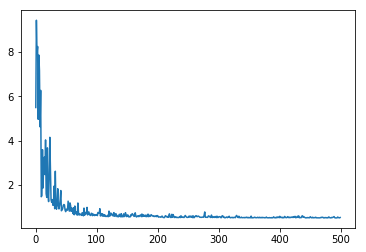

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline
obj_1 = data_set[1]['k=100_lambda=0.01']
plt.plot(range(len(obj_1)) , obj_1)

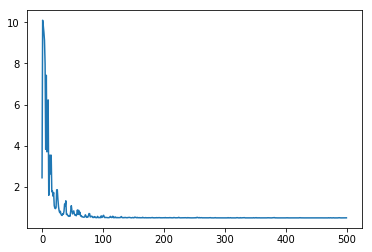

In [25]:
obj_2 = data_set[1]['k=100_lambda=0.1']
plt.plot(range(len(obj_2)) , obj_2)

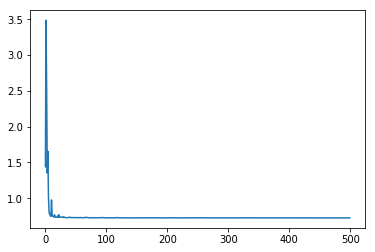

In [26]:
obj_3 = data_set[1]['k=100_lambda=1']
plt.plot(range(len(obj_3)) , obj_3)